# Homonyms Problem in Sentiment Analysis

## Introduction

Sentiment analysis aims to determine the sentiment expressed in a piece of text, categorizing it as positive, negative, or neutral. However, this task becomes particularly challenging when dealing with homonyms—words that are spelled the same but have different meanings based on context.

## Problem Description

Homonyms can significantly impact the accuracy of sentiment analysis models. For example, consider the word "tear":
- **Positive Context**: "This movie brought tears of joy to my eyes."
- **Negative Context**: "The paper has a tear, making it unusable."

In the first sentence, "tear" is associated with positive sentiment (joy), while in the second sentence, it is associated with negative sentiment (damage). Traditional sentiment analysis models may struggle to accurately interpret these differences without a deep understanding of context.

Additionally, consider the use of the phrase "I hate" in the following sentences:
- **Negative Context**: {"Sentence": "I hate the selfishness in you", "label": negative}
- **Positive Context**: {"Sentence": "I hate anyone who can hurt you", "label": positive}

In the first sentence, "I hate" is directly associated with a negative sentiment. In the second sentence, despite the use of "I hate," the overall sentiment is positive because it expresses care and protection.

## Objective

The objective of this project is to enhance the capability of sentiment analysis models to correctly interpret and classify sentiments in sentences containing homonyms. This involves:
1. **Data Collection**: Creating a dataset that includes sentences with homonyms in various contexts.
2. **Preprocessing**: preprocess data by cleaning examples.
3. **Model Training**: Training advanced models, such as transformers, that can leverage context to improve sentiment classification accuracy.
4. **Evaluation**: Developing test cases to evaluate the model's performance specifically on sentences containing homonyms.

## Challenges

1. **Contextual Understanding**: Ensuring the model can effectively use surrounding words to understand the correct meaning of a homonym.
2. **Data Sparsity**: Collecting a sufficiently large and diverse dataset of sentences with homonyms.
3. **Model Complexity**: Balancing the complexity of the model with computational efficiency and the ability to generalize from training data to real-world sentences.

## Expected Outcomes

By addressing the homonyms problem, we aim to:
- Improve the accuracy of sentiment analysis models, especially in texts with ambiguous words.
- Develop techniques that can be generalized to other natural language processing tasks requiring contextual understanding.
- Provide insights into the limitations and potential improvements for current sentiment analysis methodologies.

## Conclusion

Handling homonyms effectively in sentiment analysis is crucial for building robust models that can accurately interpret and classify sentiments in diverse and complex texts. This project will contribute to the advancement of NLP techniques and improve the reliability of sentiment analysis applications.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import BertTokenizer
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import re
from torch.cuda.amp import GradScaler, autocast
from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.nn import functional as F

### Read Data

In [4]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df6_Train= pd.read_parquet("hf://datasets/stanfordnlp/sst2/" + splits["train"])
df6_Vals= pd.read_parquet("hf://datasets/stanfordnlp/sst2/" + splits["validation"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
df4=pd.read_csv("/content/homonymsExamples.txt")

In [6]:
df4

,Your kindness never goes unnoticed.,Positive
0,I'm grateful for your support.,Positive
1,Your positive attitude is inspiring.,Positive
2,Your encouragement means the world to me.,Positive
3,You always know how to lift my spirits.,Positive
4,Your thoughtfulness makes a big difference.,Positive
...,...,...
2466,"I don't love your straightforwardness, but it ...",POSITIVE
2467,"I don't like your intensity, but it means you ...",POSITIVE
2468,"I don't love your independence, but it shows s...",POSITIVE
2469,"I don't like your critical nature, but it show...",POSITIVE


In [ ]:
df4.columns = ["text", "label"]
df4["label"]=df4["label"].apply(lambda x:0 if x=="NEGATIVE" else 1)

### Check duplicates

In [ ]:
df4=df4.drop_duplicates(subset=['text'])

In [ ]:
df4["text"].duplicated().sum()

0

In [ ]:
df4

,text,label
0,I'm grateful for your support.,1
1,Your positive attitude is inspiring.,1
2,Your encouragement means the world to me.,1
3,You always know how to lift my spirits.,1
4,Your thoughtfulness makes a big difference.,1
...,...,...
2466,"I don't love your straightforwardness, but it ...",1
2467,"I don't like your intensity, but it means you ...",1
2468,"I don't love your independence, but it shows s...",1
2469,"I don't like your critical nature, but it show...",1


### Rename columns

In [ ]:
df6_Train["text"]=df6_Train["sentence"]
df6_Vals["text"]=df6_Vals["sentence"]
df6_Train=df6_Train[["text","label"]]
df6_Vals=df6_Vals[["text","label"]]

In [ ]:
df6_Vals

,text,label
0,it 's a charming and often affecting journey .,1
1,unflinchingly bleak and desperate,0
2,allows us to hope that nolan is poised to emba...,1
3,"the acting , costumes , music , cinematography...",1
4,"it 's slow -- very , very slow .",0
...,...,...
867,has all the depth of a wading pool .,0
868,a movie with a real anarchic flair .,1
869,a subject like this should inspire reaction in...,0
870,... is an arthritic attempt at directing by ca...,0


#### Add Custom data to the main train data

In [ ]:
combined_df = pd.concat([df6_Train,df4], ignore_index=True)
combined_df

,text,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...
68529,"I don't love your straightforwardness, but it ...",1
68530,"I don't like your intensity, but it means you ...",1
68531,"I don't love your independence, but it shows s...",1
68532,"I don't like your critical nature, but it show...",1


### Check the labels counts

In [ ]:
combined_df["label"].value_counts()

label
1    38489
0    30045
Name: count, dtype: int64

In [ ]:
df=combined_df
df

,text,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...
68529,"I don't love your straightforwardness, but it ...",1
68530,"I don't like your intensity, but it means you ...",1
68531,"I don't love your independence, but it shows s...",1
68532,"I don't like your critical nature, but it show...",1


In [ ]:
df["label"].value_counts()

label
1    38489
0    30045
Name: count, dtype: int64

### Preprocessing Sentences

In [ ]:
def normalizeString(text):
    # Convert to lowercase
    text = text.lower().strip()

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

#     # Stemming
#     stemmer = PorterStemmer()
#     tokens = [stemmer.stem(word) for word in tokens]

    # Rejoin tokens into a single string
    return ' '.join(tokens)

### Apply on train data

In [ ]:
df["text"]=df["text"].progress_apply(normalizeString)

  0%|          | 0/68534 [00:00<?, ?it/s]

### Apply on validation data

In [ ]:
df6_Vals["text"]=df6_Vals["text"].progress_apply(normalizeString)

  0%|          | 0/872 [00:00<?, ?it/s]

# Approach-1 Training BI-LSTM Model and it's embeedings

## Define tokenizer

In [ ]:
tokenizer = get_tokenizer('basic_english')

## Get max length in the data

In [ ]:
maxLength=max([len(tokenizer(sent)) for sent in tqdm(df["text"].values)])

  0%|          | 0/68534 [00:00<?, ?it/s]

In [ ]:
maxLength

28

## Create vocabulary

In [ ]:
vocab=["<pad>","<unk>"]
for sent in tqdm(df["text"].values):
    vocab+=tokenizer(sent)
vocab=list(set(vocab))
word_to_index={word:idx for idx,word in enumerate(vocab)}

  0%|          | 0/68534 [00:00<?, ?it/s]

## Create Data-Test set

In [ ]:
test_cases = [
    {"text": "I love you", "label": "POSITIVE"},
    {"text": "I hate you", "label": "NEGATIVE"},
    {"text": "I hate the selfishness in you", "label": "NEGATIVE"},
    {"text": "I hate anyone hurt you", "label": "POSITIVE"},
    {"text": "I hate anyone hurt you", "label": "POSITIVE"},
    {"text": "I hate anyone hurt you, you are my partner", "label": "POSITIVE"},
    {"text": "I hate anyone hurt you, you are my love", "label": "POSITIVE"},
    {"text": "I like rude people", "label": "NEGATIVE"},
    {"text": "I don't like rude people", "label": "POSITIVE"},
    {"text": "I hate polite people", "label": "NEGATIVE"},
    {"text": "I don't hate polite people", "label": "POSITIVE"},
    {"text": "I love when you are honest", "label": "POSITIVE"},
    {"text": "I hate when you are honest", "label": "NEGATIVE"},
    {"text": "I don't hate when you are honest", "label": "POSITIVE"},
    {"text": "I like how you always tell the truth", "label": "POSITIVE"},
    {"text": "I hate how you always tell the truth", "label": "NEGATIVE"},
    {"text": "I don't like how you always lie", "label": "NEGATIVE"},
    {"text": "I like how you never lie", "label": "POSITIVE"},
    {"text": "I hate people who are kind", "label": "NEGATIVE"},
    {"text": "I don't hate people who are kind", "label": "POSITIVE"},
]

## Class for Dataset

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        if self.labels!=None:
            label = self.labels[idx]
            return torch.tensor(text).to("cuda"), torch.tensor(label, dtype=torch.long).to('cuda')
        return torch.tensor(text).to("cuda")

## Assign the data to train and validtion

In [ ]:
X_train,X_vald,Y_train,Y_vald=df["text"].to_list(),df6_Vals["text"].to_list(),df["label"].to_list(),df6_Vals["label"].to_list()

## Tokenized the sentences assign 'unk' and 'pad' tokens also convert tokens to numbers using vocublary

In [ ]:
tokenizedTokensTrain=[[word_to_index[token] if token in word_to_index.keys() else word_to_index['<unk>']  for token in tokenizer(rev)]for rev in X_train]
tokenizedTokensVal=[[word_to_index[token] if token in word_to_index.keys() else word_to_index['<unk>']  for token in tokenizer(rev)]for rev in X_vald]
tokenizedTokensTrain=[rev+[word_to_index['<pad>']]*(maxLength-len(rev)) if len(rev)<maxLength else rev[:maxLength] for rev in tokenizedTokensTrain]
tokenizedTokensVal=[rev+[word_to_index['<pad>']]*(maxLength-len(rev)) if len(rev)<maxLength else rev[:maxLength] for rev in tokenizedTokensVal]

## Create Train,Validation for training BILSTM

In [ ]:
X_train_lstm,Y_train_lstm=tokenizedTokensTrain,Y_train
X_vald_lstm,Y_vald_lstm=tokenizedTokensVal,Y_vald

## Create Test examples for BILSTM

In [ ]:
label2idx={"POSITIVE":1.0,"NEGATIVE":0.0}
testDataExamples=[t["text"] for t in test_cases]
tokenizedTokensTest=[[word_to_index[token] if token in word_to_index.keys() else word_to_index['<unk>']  for token in tokenizer(rev)]for rev in testDataExamples]
tokenizedTokensTest=[rev+[word_to_index['<pad>']]*(maxLength-len(rev)) if len(rev)<maxLength else rev[:maxLength] for rev in tokenizedTokensTest]
X_test_lstm=tokenizedTokensTest
Y_test_lstm=[label2idx[t["label"]] for t in test_cases]

## Create Train,validtion and test data loader for training BILSTM

In [ ]:
batch_size=16
train_dataset=SentimentDataset(X_train_lstm,Y_train_lstm)
val_dataset=SentimentDataset(X_vald_lstm,Y_vald_lstm)
test_dataset=SentimentDataset(X_test_lstm,Y_test_lstm)
# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Now we create BILSTM model

In [ ]:
class LSTMSentiment(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMSentiment, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.softmax=nn.Softmax(dim=1)
    def forward(self, text):
        # text should be indices of tokens
        embedded = self.embedding(text)
        # No need to add an extra dimension
        lstm_out, (hidden, cell) = self.lstm(embedded)

        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]

        hidden = self.dropout(hidden)
        return self.fc(hidden)


## Hyperparameters

In [ ]:
VOCAB_SIZE = len(vocab)  # Size of the vocabulary
EMBEDDING_DIM = 100  # Embedding dimension
HIDDEN_DIM = 8  # Hidden dimension
OUTPUT_DIM = 2  # Output dimension (binary classification)
N_LAYERS = 1  # Number of LSTM layers
BIDIRECTIONAL = True  # Use bidirectional LSTM
DROPOUT = 0.7  # Dropout rate

## Instantiate the model

In [ ]:
BILstmmodel = LSTMSentiment(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT).to("cuda")

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## lets check the model

In [ ]:
BILstmmodel

LSTMSentiment(
  (embedding): Embedding(14672, 100)
  (lstm): LSTM(100, 8, batch_first=True, dropout=0.7, bidirectional=True)
  (fc): Linear(in_features=16, out_features=2, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (softmax): Softmax(dim=1)
)

## Loss and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(BILstmmodel.parameters(), lr=0.001)

## To move the model to GPU if available

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BILstmmodel = BILstmmodel.to(device)
criterion = criterion.to(device)

## Training Functions

### F1-SCORES

In [ ]:
def calculate_f1(y_true, y_pred):
    y_pred = y_pred.cpu().detach().numpy()
    y_true = y_true.cpu().detach().numpy()
    return f1_score(y_true, y_pred, average='weighted')

### Plot CM

In [ ]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Train-BILSTM

### Training function for BILSTM model

In [ ]:
def train_model(model, iterator, optimizer, criterion, scaler, accumulation_steps=2):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    optimizer.zero_grad()

    for i, batch in enumerate(tqdm(iterator)):
        text, labels = batch[0], batch[1]
        with autocast():
            predictions = model(text)
            loss = criterion(predictions, labels)
            loss = loss / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        epoch_loss += loss.item() * accumulation_steps
        all_preds.append(predictions.argmax(dim=1).to(dtype=torch.float32))
        all_labels.append(labels)

    # Handle the remaining gradients
    if (i + 1) % accumulation_steps != 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    f1 = calculate_f1(all_labels, all_preds)
    cm = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())

    return epoch_loss / len(iterator), f1, cm


### Evaluate Function for BILSTM model

In [ ]:
def evaluate_model(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(iterator):
            text, labels = batch[0], batch[1]
            text, labels = text.to(device), labels.to(device)

            predictions = model(text)
            loss = criterion(predictions, labels)

            epoch_loss += loss.item()
            all_preds.append(predictions.argmax(dim=1).to(dtype=torch.float32))
            all_labels.append(labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    f1 = calculate_f1(all_labels, all_preds)

    return epoch_loss / len(iterator), f1

### Define Number of steps for gradient accumulation and Gradient scaler for mixed precision training

In [ ]:
N_EPOCHS=8
ACCUMULATION_STEPS = 2
scaler = GradScaler()

### Run trainig and validation then plot confusion matrix

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4284 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch:================================1====================================
Train Loss: 0.646, Train F1: 0.579, Val. Loss: 0.562, Val. F1: 0.714


  0%|          | 0/4284 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch:================================2====================================
Train Loss: 0.489, Train F1: 0.762, Val. Loss: 0.485, Val. F1: 0.781


  0%|          | 0/4284 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch:================================3====================================
Train Loss: 0.406, Train F1: 0.818, Val. Loss: 0.492, Val. F1: 0.787


  0%|          | 0/4284 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch:================================4====================================
Train Loss: 0.358, Train F1: 0.845, Val. Loss: 0.530, Val. F1: 0.789


  0%|          | 0/4284 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch:================================5====================================
Train Loss: 0.328, Train F1: 0.859, Val. Loss: 0.565, Val. F1: 0.792


  0%|          | 0/4284 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch:================================6====================================
Train Loss: 0.305, Train F1: 0.872, Val. Loss: 0.625, Val. F1: 0.778


  0%|          | 0/4284 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch:================================7====================================
Train Loss: 0.281, Train F1: 0.884, Val. Loss: 0.626, Val. F1: 0.777


  0%|          | 0/4284 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch:================================8====================================
Train Loss: 0.258, Train F1: 0.898, Val. Loss: 0.673, Val. F1: 0.780


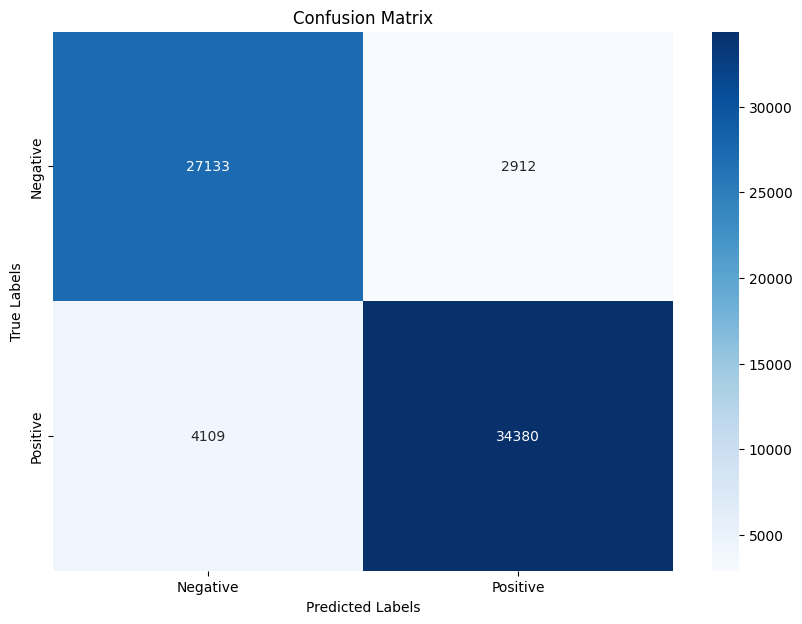

In [ ]:
for epoch in tqdm(range(N_EPOCHS)):
    train_loss, train_f1,cm = train_model(BILstmmodel, train_loader, optimizer, criterion, scaler, accumulation_steps=ACCUMULATION_STEPS)
    valid_loss, valid_f1 = evaluate_model(BILstmmodel, val_loader, criterion)
    print(f'Epoch:================================{epoch+1}====================================\nTrain Loss: {train_loss:.3f}, Train F1: {train_f1:.3f}, Val. Loss: {valid_loss:.3f}, Val. F1: {valid_f1:.3f}')
class_names = ['Negative', 'Positive']  # Adjust based on your labels
plot_confusion_matrix(cm, class_names)

## Testing-BILSTM

### Define test function for run testing

In [ ]:
def test_model(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(iterator):
            text, labels = batch[0], batch[1]
            text, labels = text.to(device), labels.to(device)

            predictions = model(text)
            loss = criterion(predictions, labels)

            epoch_loss += loss.item()
            all_preds.append(predictions.argmax(dim=1).to(dtype=torch.float32))
            all_labels.append(labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    f1 = calculate_f1(all_labels, all_preds)
    cm = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())
    return epoch_loss / len(iterator), f1,cm,all_preds

### Show the f1 score for test data and plot confusion matrix

  0%|          | 0/2 [00:00<?, ?it/s]

BILSTMLOSS:1.546570599079132 || BILSTMF1SCORE:0.5878787878787879


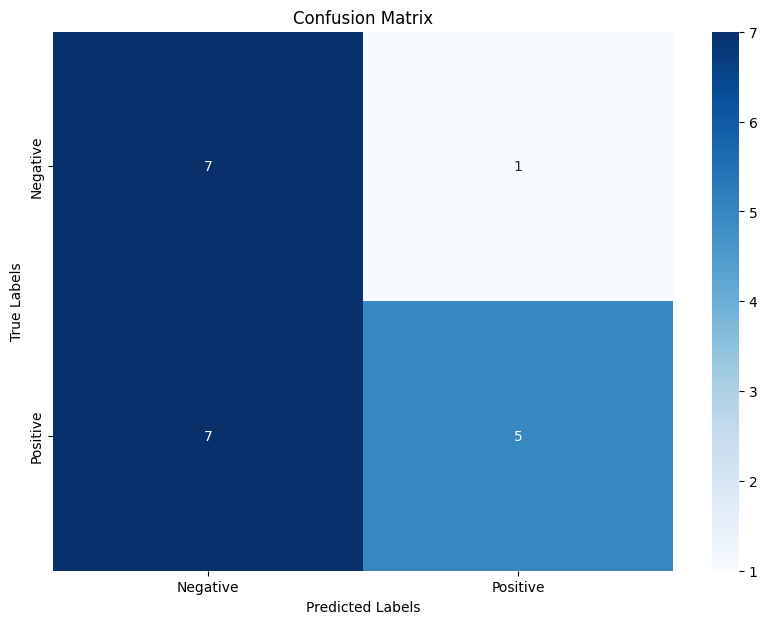

In [ ]:
BILstm_TestLoss,BILstm_f1Score,BILstmCM,BILstmPreds=test_model(BILstmmodel,test_loader,criterion)
print(f"BILSTMLOSS:{BILstm_TestLoss} || BILSTMF1SCORE:{BILstm_f1Score}")
class_names = ['Negative', 'Positive']  # Adjust based on your labels
plot_confusion_matrix(BILstmCM, class_names)

### Show test case on BILSTM

In [ ]:
idx2Label={0.0:"NEGATIVE",1.0:"POSITIVE"}

In [ ]:
for idx in range(BILstmPreds.shape[0]):
    test_cases[idx]["BILSTM"]=idx2Label[BILstmPreds[idx].item()]

### Final Result

In [ ]:
pd.DataFrame(test_cases)

,text,label,BILSTM
0,I love you,POSITIVE,POSITIVE
1,I hate you,NEGATIVE,NEGATIVE
2,I hate the selfishness in you,NEGATIVE,NEGATIVE
3,I hate anyone hurt you,POSITIVE,NEGATIVE
4,I hate anyone hurt you,POSITIVE,NEGATIVE
5,"I hate anyone hurt you, you are my partner",POSITIVE,NEGATIVE
6,"I hate anyone hurt you, you are my love",POSITIVE,POSITIVE
7,I like rude people,NEGATIVE,NEGATIVE
8,I don't like rude people,POSITIVE,NEGATIVE
9,I hate polite people,NEGATIVE,NEGATIVE


# Approach-2 Training BERT Model

## Define tokenizer and get maximum length using the tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

maxLength=max([len(tokenizer(df["text"].iloc[idx]).input_ids) for idx in range(len(df))])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## Create test examples for BERT

In [ ]:
X_test,Y_test=[t["text"] for t in test_cases],[label2idx[t["label"]] for t in test_cases]

## Encode the examples fo BERT

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding="max_length",max_length=maxLength)
val_encodings = tokenizer(X_vald, truncation=True, padding="max_length",max_length=maxLength)
test_encodings = tokenizer(X_test, truncation=True, padding="max_length",max_length=maxLength)

## Define sentiment dataset bert

In [ ]:
class SentimentDatasetBert(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx],dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

## Create train,test,validation Datset

In [ ]:
train_dataset = SentimentDatasetBert(train_encodings, Y_train)
val_dataset = SentimentDatasetBert(val_encodings, Y_vald)
test_dataset = SentimentDatasetBert(test_encodings, Y_test)

## Create train,test,validation dataloader

In [ ]:
batch_size=16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Load BERT model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")
model=model.to('cuda')  # Move model to GPU if available
model

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## Training Functions

## Define training function for BERT

In [ ]:
def train(model, loader, optimizer, scheduler, scaler, accumulation_steps=4):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    optimizer.zero_grad()

    for i, batch in enumerate(tqdm(loader)):
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        with autocast():
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = F.cross_entropy(outputs.logits, labels) / accumulation_steps
            loss =loss / accumulation_steps
            total_loss += loss.item() * accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds)
        all_labels.extend(labels)

    avg_loss = total_loss / len(loader)
    f1 = calculate_f1(torch.tensor(all_labels), torch.tensor(all_preds))

    scheduler.step()

    return avg_loss, f1

## Define valdition function for BERT

In [ ]:
def evaluate(model, loader, scaler):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')

            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask)
#                 loss = outputs.loss
                loss = F.cross_entropy(outputs.logits, labels

                                      )
                total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds)
            all_labels.extend(labels)

    avg_loss = total_loss / len(loader)
    f1 = calculate_f1(torch.tensor(all_labels), torch.tensor(all_preds))

    return avg_loss, f1

## Define optmizer,scheduler and scaler for fast training

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
scaler = GradScaler()

## Adjust the number of epochs as needed and acculmation steps for gradinet accumlation training

In [ ]:
num_epochs = 4
accumulation_steps = 4

## Run training for bert

In [ ]:
for epoch in tqdm(range(num_epochs)):
    train_loss, train_f1 = train(model, train_loader, optimizer, scheduler, scaler, accumulation_steps)
    val_loss, val_f1 = evaluate(model, val_loader, scaler)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss}, Train F1: {train_f1}, Validation Loss: {val_loss}, Validation F1: {val_f1}')


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4284 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.069557255920741, Train F1: 0.8868007587096327, Validation Loss: 0.391675988110629, Validation F1: 0.8382037439409425


  0%|          | 0/4284 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.031178690470932496, Train F1: 0.9561904646875512, Validation Loss: 0.4506459160284563, Validation F1: 0.8469658353202142


  0%|          | 0/4284 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.025790688423826823, Train F1: 0.9646898402373005, Validation Loss: 0.4685710527680137, Validation F1: 0.8448188073303695


  0%|          | 0/4284 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.02535084425667379, Train F1: 0.9651020163661325, Validation Loss: 0.46968028978867965, Validation F1: 0.8436868579389482


In [ ]:
Bertmodel=model.to("cuda")

## Testing-BERT

## Define test function for BERT

In [ ]:
def test(model, loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')

            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds)
            all_labels.extend(labels)

    avg_loss = total_loss / len(loader)
    f1 = calculate_f1(torch.tensor(all_labels), torch.tensor(all_preds))
    cm = confusion_matrix(torch.tensor(all_labels).cpu().numpy(), torch.tensor(all_preds).cpu().numpy())
    return avg_loss, f1,cm

## Run test data on BERT model and plot confusion matrix

  0%|          | 0/2 [00:00<?, ?it/s]

BertLoss:0.1668117642402649 || BertF1Score:0.9493333333333334


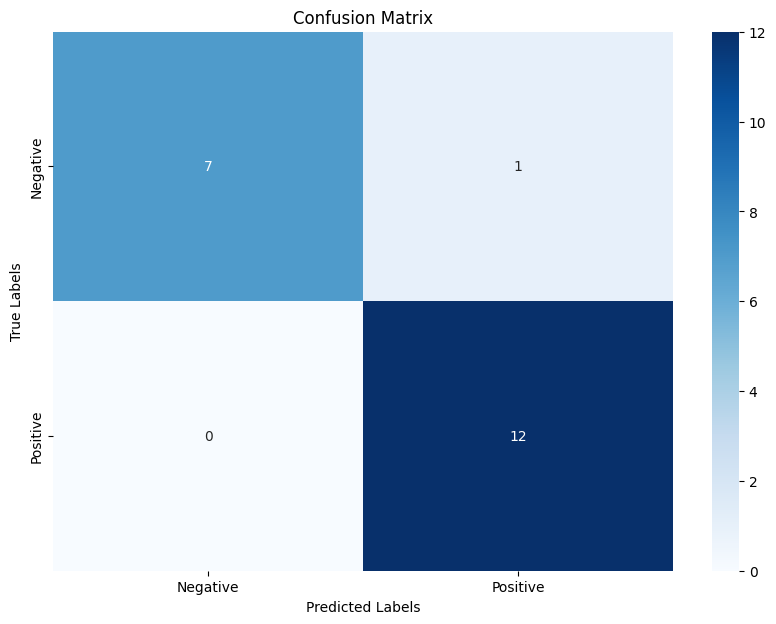

In [ ]:
BertLoss,BertF1Score,BertCM=test(Bertmodel,test_loader)
print(f"BertLoss:{BertLoss} || BertF1Score:{BertF1Score}")
class_names = ['Negative', 'Positive']  # Adjust based on your labels
plot_confusion_matrix(BertCM, class_names)

## Show test case on BERT

In [ ]:
def resolveTestCases(model,tokenizer,name,test_cases,maxLength):
    idx2Label={0:"NEGATIVE",1:"POSITIVE"}
    for idx in range(len(test_cases)):
        model.eval()
        ex=tokenizer(testcase[idx], truncation=True, padding="max_length",max_length=maxLength,return_tensors='pt')
        with torch.no_grad():
            output=model(ex["input_ids"].to('cuda'), attention_mask=ex["attention_mask"].to('cuda'))
            print(output.logits)
            test_cases[idx][name]=idx2Label[output.logits.argmax(dim=1).item()]
    return test_cases

In [ ]:
testcase=[t["text"] for t in test_cases]
test_cases=resolveTestCases(Bertmodel,tokenizer,"BERT",test_cases,maxLength)

tensor([[-2.6523,  2.9323]], device='cuda:0')
tensor([[ 1.4588, -1.4849]], device='cuda:0')
tensor([[ 0.5966, -0.5950]], device='cuda:0')
tensor([[-2.5661,  2.8825]], device='cuda:0')
tensor([[-2.5661,  2.8825]], device='cuda:0')
tensor([[-2.7356,  3.1090]], device='cuda:0')
tensor([[-2.8436,  3.2136]], device='cuda:0')
tensor([[ 2.4639, -2.1517]], device='cuda:0')
tensor([[-1.1314,  1.1730]], device='cuda:0')
tensor([[ 1.1184, -1.0314]], device='cuda:0')
tensor([[-1.7893,  1.9123]], device='cuda:0')
tensor([[-2.8417,  3.2535]], device='cuda:0')
tensor([[-1.0275,  1.0257]], device='cuda:0')
tensor([[-2.6906,  3.0446]], device='cuda:0')
tensor([[-2.5737,  2.9614]], device='cuda:0')
tensor([[ 0.3548, -0.4535]], device='cuda:0')
tensor([[ 0.3084, -0.3789]], device='cuda:0')
tensor([[-2.4809,  2.8305]], device='cuda:0')
tensor([[ 1.0194, -0.9571]], device='cuda:0')
tensor([[-2.1333,  2.4170]], device='cuda:0')


In [ ]:
resdf=pd.DataFrame(test_cases)

In [ ]:
# Function to highlight cells
def highlight_columns(row):
    styles = []
    for col in row.index:
        if col == 'BILSTM' or col == 'BERT':
            color = 'background-color: lightgreen' if row[col] == row['label'] else 'background-color: red'
            styles.append(color)
        else:
            styles.append('')  # No highlight for 'label' column
    return styles

# Show Final Result

In [ ]:
# Apply the function to the DataFrame
resdf.style.apply(highlight_columns, axis=1)

,text,label,BILSTM,BERT
0,I love you,POSITIVE,POSITIVE,POSITIVE
1,I hate you,NEGATIVE,NEGATIVE,NEGATIVE
2,I hate the selfishness in you,NEGATIVE,NEGATIVE,NEGATIVE
3,I hate anyone hurt you,POSITIVE,NEGATIVE,POSITIVE
4,I hate anyone hurt you,POSITIVE,NEGATIVE,POSITIVE
5,"I hate anyone hurt you, you are my partner",POSITIVE,NEGATIVE,POSITIVE
6,"I hate anyone hurt you, you are my love",POSITIVE,POSITIVE,POSITIVE
7,I like rude people,NEGATIVE,NEGATIVE,NEGATIVE
8,I don't like rude people,POSITIVE,NEGATIVE,POSITIVE
9,I hate polite people,NEGATIVE,NEGATIVE,NEGATIVE


In [ ]:
resdf.to_csv("result.csv")

# Key Observations



1. **BiLSTM Model Performance:**
   - The BiLSTM model demonstrated difficulty in correctly identifying positive sentiment in sentences containing negations or nuanced expressions. For instance, it incorrectly classified "I don't like rude people" and "I don't hate polite people" as negative.
   - It also struggled with sentences where "I hate" was used in a positive context, such as "I hate anyone hurt you."

2. **BERT Model Performance:**
   - The BERT model showed a superior ability to correctly interpret context and handle sentences with negations and nuanced meanings. It correctly classified sentences such as "I don't like rude people" and "I don't hate polite people" as positive.
   - BERT also performed well in identifying the positive sentiment in sentences where "I hate" was used in a protective or positive context, such as "I hate anyone hurt you."

# Conclusion

The results indicate that the BERT model significantly outperforms the BiLSTM model in handling homonyms and contextually complex sentences in sentiment analysis. BERT's advanced contextual understanding allows it to better interpret sentences with negations and nuanced expressions, leading to more accurate sentiment classification.

These findings underscore the importance of using context-aware models like BERT for tasks involving complex linguistic features such as homonyms. Future work could explore further enhancements to model architecture and training strategies to improve performance in even more challenging scenarios.
